In [1144]:
!pip install torch

In [1145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd

from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score

In [1146]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [1147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [923]:
# df = pd.read_csv('./data/2010-201720*20.csv')

In [1151]:
import os
# injection data
inputdir = "data/yearly"
# inputdir = "datasets/OCC_injection_data/MonthlyInjectionRecords"
df = pd.DataFrame()

for root, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        if ".csv" in filename:
            tmp_df = pd.read_csv(os.path.join(root, filename))
            print(len(tmp_df))
            df = df.append(tmp_df, ignore_index=True)

900
900
900
900
900
900
900
900


In [896]:
df= df.drop(['HF_number', 'HF_Base_Water_Volume', 'HF_Base_NoWater_Volume'], 1)

In [897]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)

In [898]:
df['class'].value_counts()

0    5846
1    1354
Name: class, dtype: int64

In [899]:
feature_names = df.columns.tolist()[:-1]

/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


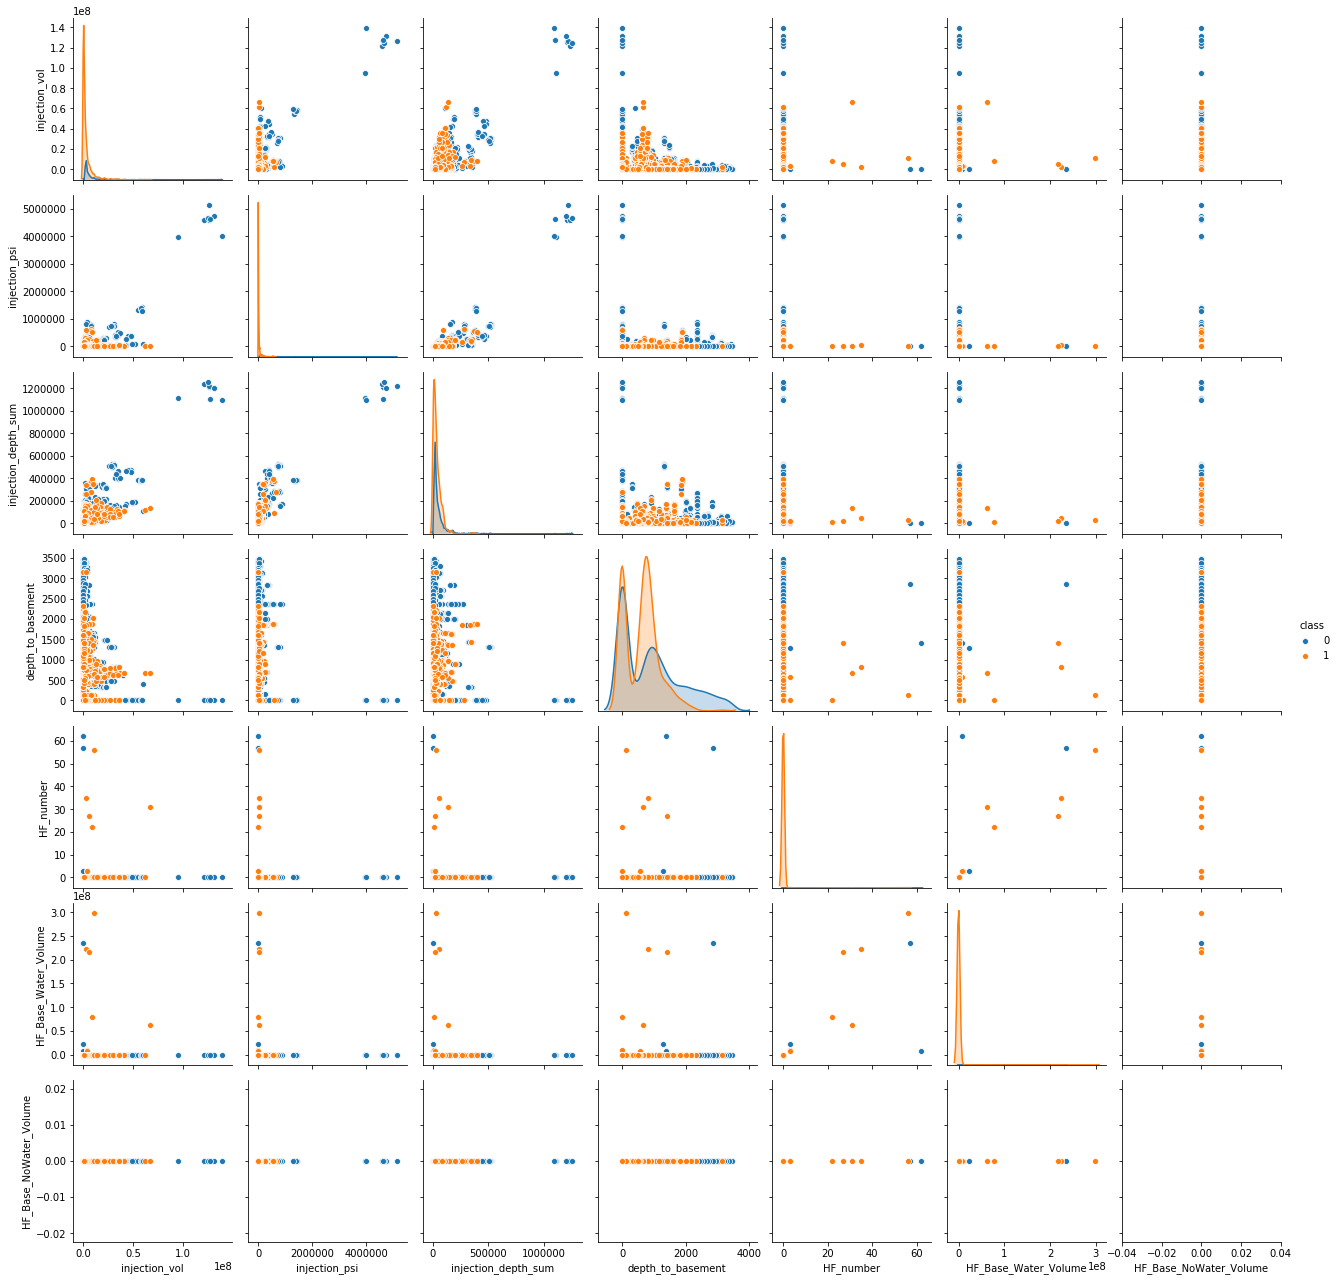

In [831]:
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn作为matplotlib的补充，导入后会覆盖matplotlib的默认作图风格

sns.pairplot(df, hue='class', vars=feature_names)  # hue : 使用指定变量为分类变量画图；vars : 与data使用，否则使用data的全部变量
plt.show()  # 仍然使用matplotlib的显示函数

In [810]:
# def normalize(df):
#     return (df - df.min()) / ( df.max() - df.min())

# features = normalize(features)

In [901]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, n_output)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.linear3(sigmoid_out2)

In [902]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, feature_number))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [903]:
# 测试模型是否可用
# x = torch.rand((100,feature_number))
# print(x)
# model = Net(feature_number,20,2)
# result = model(x)
# print (result)
# model = model.to(device)

# Train the model, validation and evaluation

In [912]:
# Define the hyperparameters
seed = 42
lr = 1e-3
momentum = 0.8
batch_size = 32
test_batch_size = 32
n_epochs = 200

feature_number = len(feature_names)
model = Net(feature_number,2)

In [913]:
features = df.iloc[:,0:-1]
target = df['class']
targets = target.values
features = features.values
data_tensor = TensorDataset(torch.tensor(features), torch.tensor(targets))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(features, targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
train_dataset = torch.utils.data.Subset(data_tensor, indices[0])
val_dataset = torch.utils.data.Subset(data_tensor, indices[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [914]:
print(len(train_dataset))
print(len(val_dataset))

6480
720


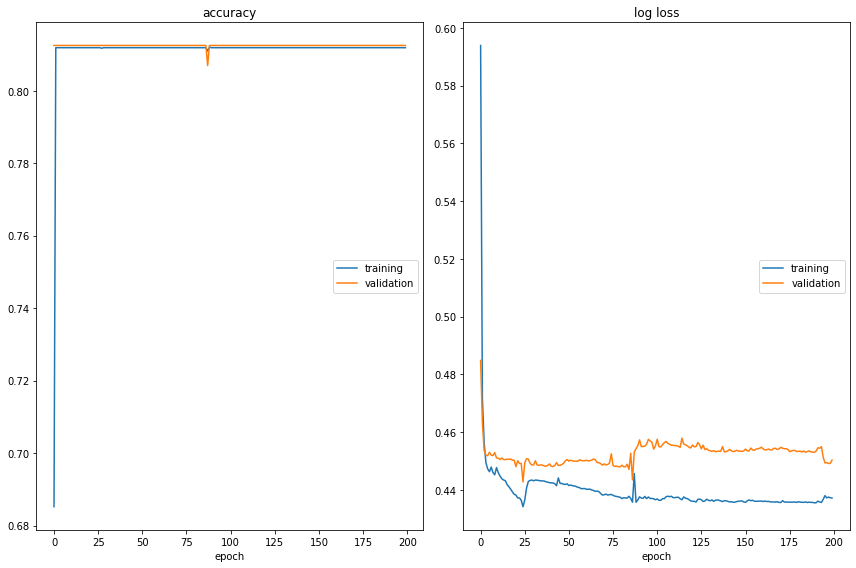

accuracy
	training         	 (min:    0.685, max:    0.812, cur:    0.812)
	validation       	 (min:    0.807, max:    0.812, cur:    0.812)
log loss
	training         	 (min:    0.434, max:    0.594, cur:    0.437)
	validation       	 (min:    0.443, max:    0.485, cur:    0.450)
Avg. Test Loss: 0.450  Avg. Test Accuracy: 0.812



In [915]:
set_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()


test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

In [916]:
model.eval()
test_features = features[indices[1]]
test_labels = targets[indices[1]]
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8125


# Feature Importance

In [917]:
from captum.attr import FeaturePermutation, IntegratedGradients

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(18,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

Average Feature Importances
injection_vol :  0.404
injection_psi :  -0.035
injection_depth_sum :  -0.034
depth_to_basement :  0.086


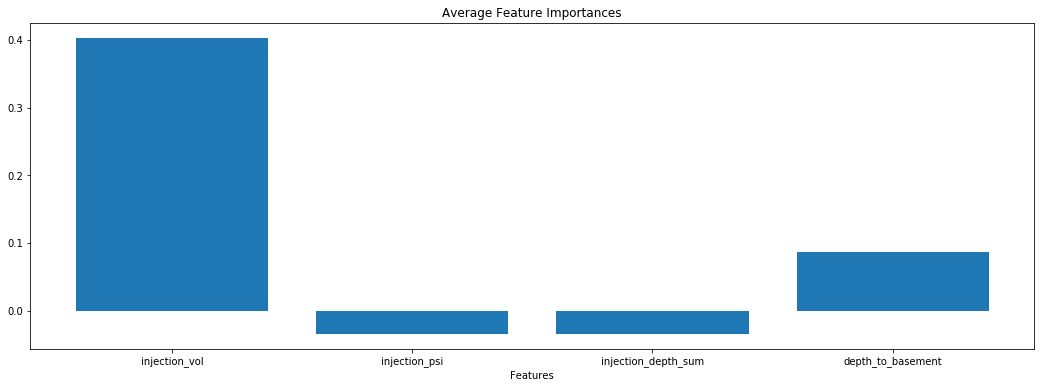

In [918]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

# Save the model

In [783]:
model.eval()
model.parameters()
path = "./model/Earthquake Predict6.pt"
torch.save(model.state_dict,path)

In [920]:
model.eval()
test_features = features
test_labels = targets
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8119444444444445


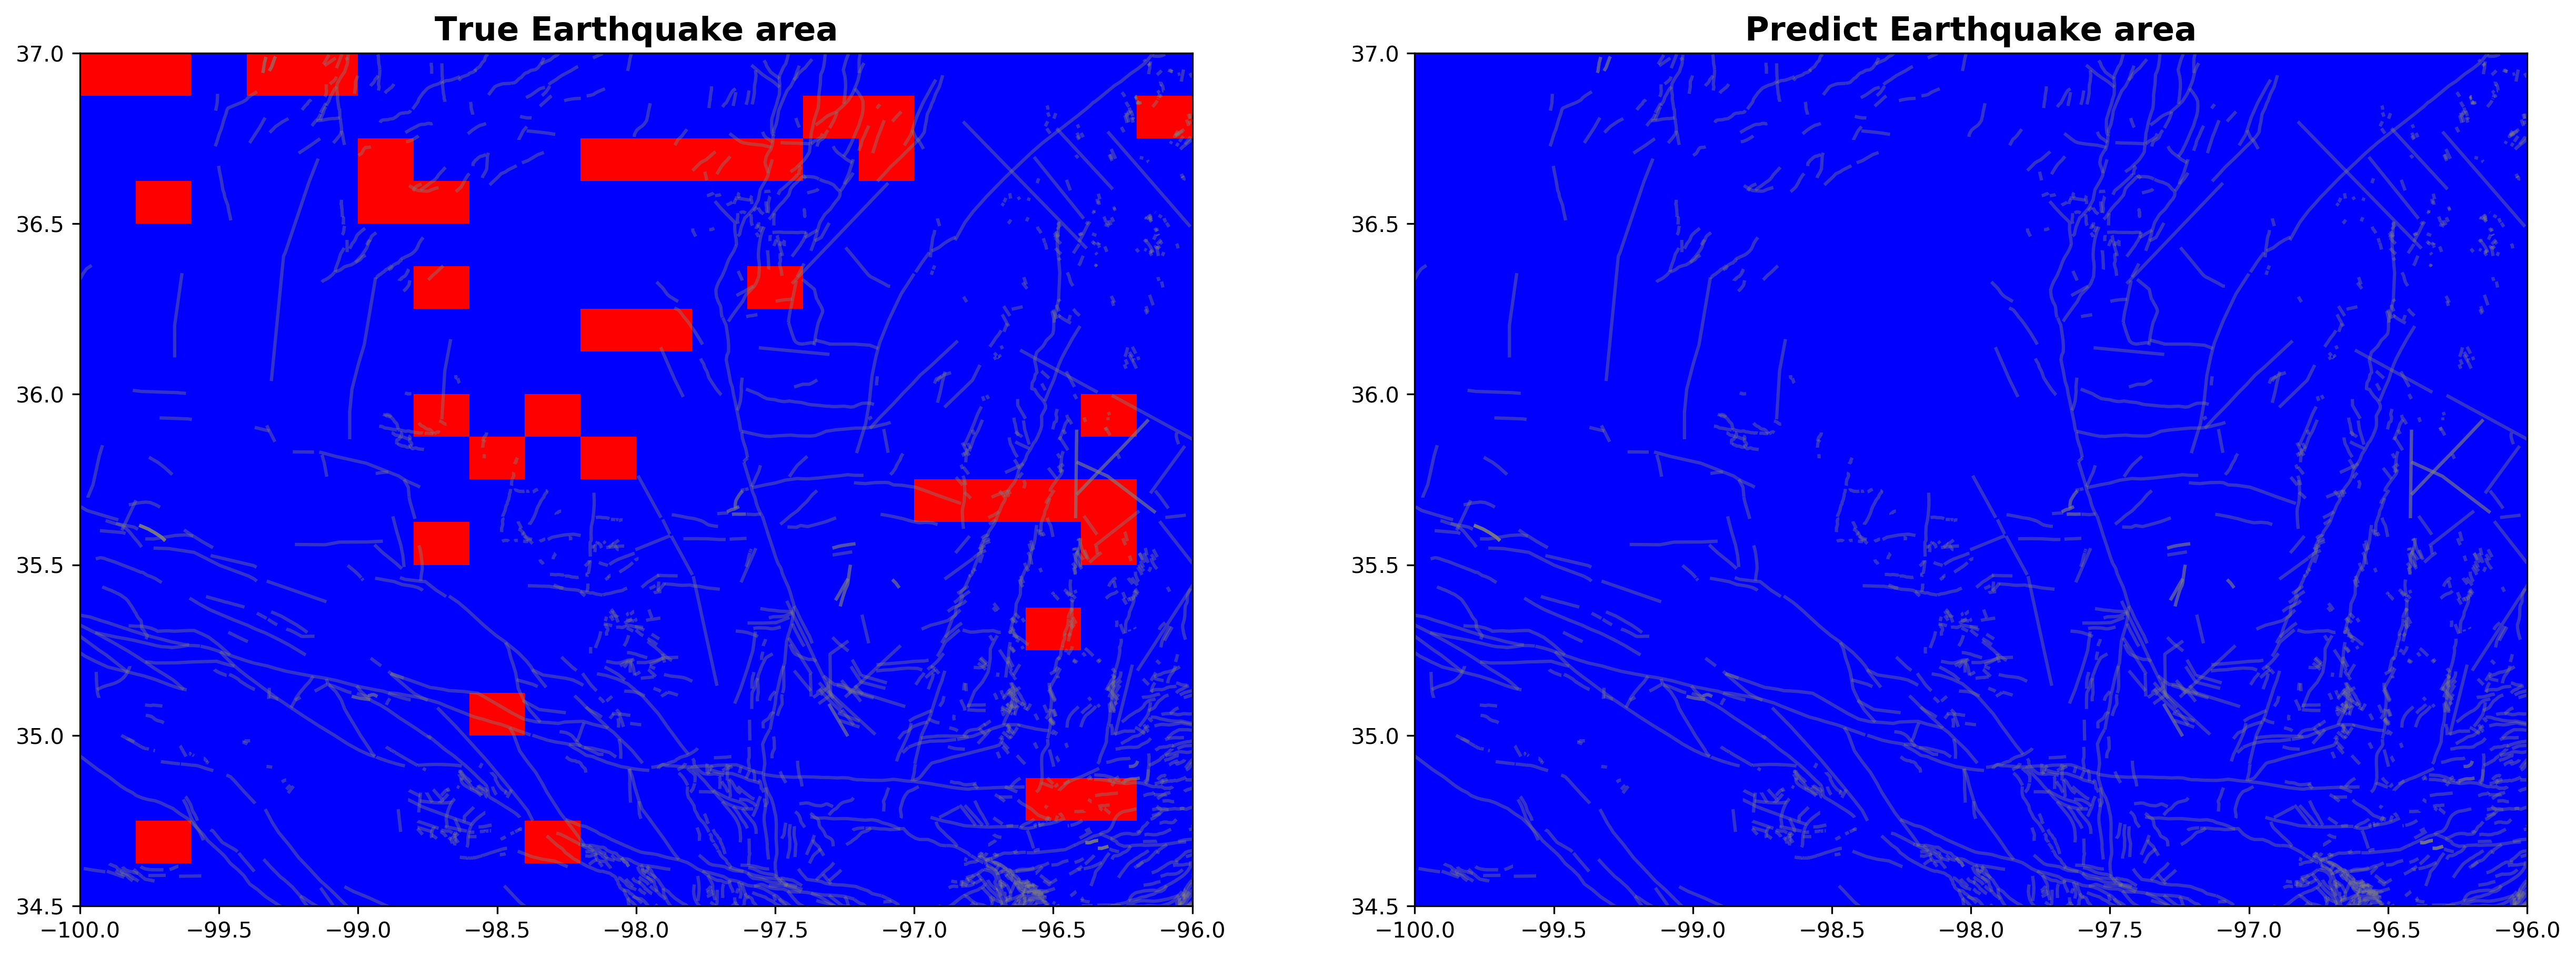

In [921]:
m, n = (21, 21)
x = np.linspace(-100, -96, m)
y = np.linspace(34.5, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax2.set_xlim(-100, -96)
ax2.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
ax2.set_title('Predict Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# 线性模型

In [855]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [862]:
df

,injection_vol,injection_psi,injection_depth_sum,depth_to_basement,HF_number,HF_Base_Water_Volume,HF_Base_NoWater_Volume,class
0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
7195,0.0,0.0,0.0,0.0,0,0.0,0.0,0
7196,0.0,0.0,0.0,0.0,0,0.0,0.0,0
7197,0.0,0.0,0.0,0.0,0,0.0,0.0,0
7198,0.0,0.0,0.0,0.0,0,0.0,0.0,0


In [856]:
data = df.copy(deep=True)

In [864]:
#特征features
X = df.iloc[:,0:-1]
#标签labels
Y = df['class']

In [866]:
from sklearn.model_selection import train_test_split

In [874]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8)

In [875]:
#输出数据大小
print('原始数据特征：',X.shape,
     '训练数据特征：',X_train.shape,
      '测试数据特征',X_test.shape)

print('原始数据标签：',Y.shape,
     '训练数据标签：',y_train.shape,
      '测试数据标签',y_test.shape)

原始数据特征： (7200, 7) 训练数据特征： (5760, 7) 测试数据特征 (1440, 7)
原始数据标签： (7200,) 训练数据标签： (5760,) 测试数据标签 (1440,)


In [876]:
#绘制散点图
import matplotlib.pyplot as plt

# #散点图
# plt.scatter(X_train,y_train,color='b',label='train data')
# plt.scatter(X_test,y_test,color='r',label='test data')

# #添加图标标签
# plt.legend(loc=2)
# plt.xlabel('Time')
# plt.ylabel('Score')
# #显示图像
# plt.show()

In [877]:
#将训练数据特征转换成二维数组X行*1列
X_train=X_train.values.reshape(-1,7)
#将测试数据特征转换成二维数组X行*1列
X_test=X_test.values.reshape(-1,7)

In [879]:
X_test

array([[0.000000e+00, 0.000000e+00, 4.510000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.128119e+06, 1.496000e+04, 4.410000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [6.549726e+06, 1.133000e+04, 3.774900e+04, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.726000e+03, 1.620000e+03, 2.649000e+03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [7.771760e+05, 0.000000e+00, 1.620000e+04, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [880]:
#第一步：导入逻辑回归
from sklearn.linear_model import LogisticRegression
#第二步：创建模型：逻辑回归
model=LogisticRegression()
#第三步：训练模型
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [881]:
#评估模型：准确率
model.score(X_test,y_test)

0.8152777777777778